# Experiment - Prompting OpenAI API

## Prepare Notebook

In [1]:
import os
import sys
import logging
import warnings
warnings.filterwarnings("ignore")

INSTALL_DEPS = False
if INSTALL_DEPS:
    %pip install openai==1.51.2

%load_ext dotenv

FUNDAMENTALS_PATH = os.getenv("FUNDAMENTALS_PATH")
LLM_PROMPTS_PATH = os.getenv("LLM_PROMPTS_PATH")
FUNDAMENTALS_PATH = os.getenv("FUNDAMENTALS_PATH")
HISTORIC_PATH = os.getenv("HISTORIC_PATH")
MACRO_PATH = os.getenv("MACRO_PATH")
OPTIONS_PATH = os.getenv("OPTIONS_PATH")
LLM_OUTPUT_PATH = os.getenv("LLM_OUTPUT_PATH")
LOGS_PATH = os.getenv("LOGS_PATH")
paths = [LLM_OUTPUT_PATH, LOGS_PATH]
for path in paths:
    if path and not os.path.exists(path):
        os.makedirs(path)

if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    logging.info("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    DATA_PATH = "/kaggle/input/drl-dataset-quant"
    FUNDAMENTALS_PATH = DATA_PATH + FUNDAMENTALS_PATH
    HISTORIC_PATH = DATA_PATH + HISTORIC_PATH
    MACRO_PATH = DATA_PATH + MACRO_PATH
    OPTIONS_PATH = DATA_PATH + OPTIONS_PATH

    sys.path.insert(1, "/kaggle/usr/lib/drlutil")

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from openai import OpenAI

module_path = os.path.abspath(os.path.join(os.getcwd(), 'utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_utils import *
from thesis_utils import *

2025-05-30 13:51:50.115375: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 13:51:50.471557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 13:51:50.471595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 13:51:50.524018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 13:51:50.644797: I tensorflow/core/platform/cpu_feature_guar

## Environment and Constants

In [3]:
START_DATE = '20120101'
END_DATE = '20200101'
TARGET = "AAPL"
OPENAI_MODEL = os.getenv("OPENAI_MODEL") # Best use a more rationale model like 4o or 1o.
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [4]:
output_file = f"{HISTORIC_PATH}/engineered_{TARGET}_data.parquet"
stock_aug_data = pd.read_parquet(output_file)
stock_aug_data.set_index('Date', inplace=True)
stock_aug_data.tail(3)


,Open,High,Low,Close,Volume,IV_Open,IV_High,IV_Low,IV_Close,IV_Volume,...,Volume_Weighted_Returns,BB_Upper,BB_Middle,BB_Lower,BB_Width,IV_Percentile,VIX_Impact,Momentum_Long,Momentum_Short,content
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-28 00:00:00+00:00,138.06,138.78,134.35,134.87,15324630.0,0.388195,0.402816,0.376258,0.377369,1.0,...,174049.113732,137.583480,133.274,128.964520,0.063906,0.866528,27.534988,True,False,[<p>The rise of bitcoin has been one of the to...
2020-12-29 00:00:00+00:00,135.54,135.99,133.40,133.72,11611722.0,0.382607,0.387100,0.375305,0.380417,1.0,...,40859.233718,137.720537,133.642,129.563463,0.061001,0.932918,58.740482,True,False,[<p>Some people see day trading as a dream job...
2020-12-30 00:00:00+00:00,134.05,134.73,131.73,132.69,11174161.0,0.384131,0.387116,0.376623,0.383544,1.0,...,38908.628047,137.323588,133.988,130.652412,0.050276,1.000000,108.299927,True,False,"[<p>In the exchange traded funds industry, rec..."


# Expert Examples

In [5]:
expert_df = expert_trades(stock_aug_data.copy())
expert_df.tail(3)


,Open,High,Low,Close,Volume,IV_Open,IV_High,IV_Low,IV_Close,IV_Volume,...,content,Entry_Point,Take_Profit,Stop_Loss,Timeframe,Expert_Action,trade_action,Next_Day_Returns,Next_Week_Returns,Next_Month_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-28 00:00:00+00:00,138.06,138.78,134.35,134.87,15324630.0,0.388195,0.402816,0.376258,0.377369,1.0,...,[<p>The rise of bitcoin has been one of the to...,135.54435,131.49825,138.932959,5.0,SHORT,0,-0.008527,NaN,NaN
2020-12-29 00:00:00+00:00,135.54,135.99,133.40,133.72,11611722.0,0.382607,0.387100,0.375305,0.380417,1.0,...,[<p>Some people see day trading as a dream job...,134.38860,130.37700,137.748315,5.0,SHORT,0,-0.007703,NaN,NaN
2020-12-30 00:00:00+00:00,134.05,134.73,131.73,132.69,11174161.0,0.384131,0.387116,0.376623,0.383544,1.0,...,"[<p>In the exchange traded funds industry, rec...",133.35345,129.37275,136.687286,5.0,SHORT,0,NaN,NaN,NaN


In [6]:
sample_start_date = pd.Timestamp("2019-05-01 00:00:00+02:00")
sample_end_date = pd.Timestamp("2019-07-30 00:00:00+02:00")

engineered_sample_df = stock_aug_data.loc[sample_start_date:sample_end_date]
expert_sample_df = expert_df.loc[sample_start_date:sample_end_date]
engineered_sample_df.tail(3)

,Open,High,Low,Close,Volume,IV_Open,IV_High,IV_Low,IV_Close,IV_Volume,...,Volume_Weighted_Returns,BB_Upper,BB_Middle,BB_Lower,BB_Width,IV_Percentile,VIX_Impact,Momentum_Long,Momentum_Short,content
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-25 00:00:00+00:00,51.85,52.43,51.85,51.94,12299492.0,0.259834,0.260024,0.246753,0.249627,1.0,...,87067.714204,52.344475,51.978,51.611525,0.014111,0.000000,21.025475,True,False,[<p>Shares of <strong>Intel Corporation </stro...
2019-07-28 00:00:00+00:00,52.12,52.66,52.11,52.42,17333512.0,0.247611,0.261802,0.247611,0.259358,1.0,...,41194.765580,52.556596,52.100,51.643404,0.017421,0.901471,11.891137,True,False,"[<p>On <a href=""https://www.cnbc.com/video/201..."
2019-07-29 00:00:00+00:00,52.19,52.54,51.83,52.20,16886052.0,0.258389,0.273407,0.255167,0.261152,1.0,...,5980.544385,52.552735,52.098,51.643265,0.017423,1.000000,8.150233,True,False,[<p>Earnings season is upon us! As the markets...


# Initialize LLM

In [7]:
import yaml
import pickle
from pydantic import BaseModel
from enum import Enum
from textwrap import dedent
from typing import List
from pprint import pprint


def enum_to_str_representer(dumper, data):
    """Helper function to represent enums as their string values in YAML."""
    return dumper.represent_str(data.value)

yaml.add_representer(Action, enum_to_str_representer)

OPENAI_CLIENT = OpenAI(api_key=OPENAI_API_KEY)


In [8]:
RISK_EXPERIMENT = 'r'
TRAIN_PROMPT_YML = f'{LLM_PROMPTS_PATH}/writer_trainer_v1.yml'

TICKERS = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "META"]
PROMPT_SAMPLES = 5

In [9]:
from typing import List
from pydantic import BaseModel


class ExpertReview(BaseModel):
    explanation: str
    features: List[str]

class ReflectTradeStrategy(BaseModel):
    reflection: str
    suggestions: List[str]
    features: List[str]
    explanation: str

def train_trade_strategy(step, context, persona, client, model, response_format=ExpertReview, top_k_tokens=5, max_retries=2):
    retries = 0
    response_data = None
    while retries < max_retries:
        try:
            response = client.beta.chat.completions.parse(
                model=model,
                messages=[
                    {"role": "user", "content": f"Step: {step}\nPrompt: {context}\n"}
                ],
                temperature=0.7,
                top_p=1,
                top_logprobs=top_k_tokens,
                response_format=response_format,
                max_completion_tokens=3500,
                frequency_penalty=1,
                presence_penalty=0.25,
                logprobs=True,
            )

            trade_strategy_response = response.choices[0].message
            trade_strategy = trade_strategy_response.parsed if isinstance(trade_strategy_response.parsed, dict) else trade_strategy_response.parsed.__dict__

            if trade_strategy is None:
                raise Exception("trade_strategy None!")

            total_tokens = response.usage.total_tokens
            prompt_tokens = response.usage.prompt_tokens
            completion_tokens = response.usage.completion_tokens
            cost = ((prompt_tokens / 1_000_000) * 0.15) + ((completion_tokens / 1_000_000) * 0.6)



            token_logprobs = response.choices[0].logprobs.content
            perplexity = calc_uncertainty_metrics(response.choices[0].logprobs.content)
            long_token_proba = -float('inf')
            short_token_proba = -float('inf')

            for token_probs in token_logprobs:
                if Action.LONG.value in token_probs.token:
                    long_token_proba = token_probs.logprob
                if Action.SHORT.value in token_probs.token:
                    short_token_proba = token_probs.logprob

            response_data = {
                "features": trade_strategy['features'] if 'features' in trade_strategy else np.nan,
                "explanation": trade_strategy['explanation'] if 'explanation' in trade_strategy else np.nan,
                "long_token_proba": long_token_proba,
                "short_token_proba": short_token_proba,
                "perplexity": perplexity["perplexity"],
                "entropy": perplexity["entropy"],
                "tokens_meta": {
                    "total_tokens": total_tokens,
                    "prompt_tokens": prompt_tokens,
                    "completion_tokens": completion_tokens,
                    "cost": cost
                },
            }
            return response_data  # Return once successful

        except Exception as e:
            logging.error(f"Error in LLM call: {e}")
            retries += 1
            logging.info(f"Retrying LLM call ({retries}/{max_retries})...")

    if response_data is None:
        raise Exception(f"None strategy encountered after {max_retries} retries")

    return response_data

context = update_historical_data_context(engineered_sample_df.head(1),
                                         PERSONA,
                                         HIGH_RISK_PROFILE,
                                         HIGH_OBJECTIVES,
                                         expert_df=expert_sample_df)


train_template = load_yaml_template(TRAIN_PROMPT_YML)
filled_template = fill_yaml_template(context, train_template)
context_yaml = yaml.dump(filled_template, default_flow_style=True, allow_unicode=True)

trade_strategy = train_trade_strategy(1, context_yaml, PERSONA, OPENAI_CLIENT, OPENAI_MODEL)

pprint(trade_strategy)

{'entropy': 0.8028024367495347,
 'explanation': "The expert's decision to initiate a short position aligns "
                'closely with the portfolio objectives of developing a trading '
                'strategy based on volatility, events, and price action, '
                'particularly in a high-risk context. The decision is '
                'primarily driven by recent trends observed across several '
                'data categories. Firstly, the stock data indicates that the '
                'stock has a negative historical volatility (HV) and implied '
                'volatility (IV), suggesting muted market expectations '
                'regarding future price movement. An RSI value of 67.67 '
                'signals that the stock is nearing overbought conditions which '
                'often precedes reversals in bullish momentum—particularly '
                'relevant given its divergence trend.\n'
                '\n'
                'From macroeconomic indicator

In [10]:
def generate_trade_prompt(engineered_df,
                            anchor_date,
                            risk_profile,
                            objectives,
                            persona,
                            client, model,
                            prev_trade_decision = None,
                            prev_trade_returns = None,
                            prev_trade_days = None,
                            yaml_file = TRAIN_PROMPT_YML,
                            Peak_Returns=None,
                            Trough_Returns=None,
                            expert_df=None):
    train_template = load_yaml_template(yaml_file)
    sample_engineered_df = engineered_df.loc[anchor_date - pd.Timedelta(days=1):anchor_date]
    if sample_engineered_df.empty:
        return None, None, None

    # Update context with historical data
    context = update_historical_data_context(
        engineered_df=sample_engineered_df.head(1),
        persona=PERSONA,
        HIGH_RISK_PROFILE=risk_profile,
        HIGH_OBJECTIVES=objectives,
        Last_LLM_Strat=prev_trade_decision,
        Last_LLM_Strat_Returns=prev_trade_returns,
        Last_LLM_Strat_Days = prev_trade_days,
        Peak_Returns=Peak_Returns,
        Trough_Returns=Trough_Returns,
        expert_df=expert_df,
    )
    filled_template = fill_yaml_template(context, train_template)
    context_yaml = yaml.dump(filled_template, default_flow_style=True, allow_unicode=True)

    trade_strategy_response = train_trade_strategy(1, context_yaml, persona, client, model)
    trade_strategy_response["trade_action"] = 1 if context['Expert_Action'] == "Long" else 0

    return trade_strategy_response

strategy = generate_trade_prompt(engineered_df=engineered_sample_df,
                                anchor_date=pd.to_datetime("20190612", utc=True),
                                risk_profile=HIGH_RISK_PROFILE,
                                objectives=HIGH_OBJECTIVES,
                                persona=PERSONA,
                                client=OPENAI_CLIENT,
                                model=OPENAI_MODEL,
                                expert_df=expert_sample_df)
pprint(strategy)

{'entropy': 0.7281427432836893,
 'explanation': "The expert's decision to take a short position is supported "
                'by several critical indicators across different data '
                'categories that align with the high-risk portfolio '
                'objectives. Key findings include: 1) **Stock Data** reveals '
                'negative weekly returns (-10.92%) and resistance near '
                'historical highs, suggesting potential reversals; 2) The '
                '**Technical Analysis** shows an RSI value of 58.69, '
                'indicating overbought conditions but not extreme enough to '
                'signal immediate action; however, the MACD trend indicates '
                'weakening momentum (Signal Line at -0.77); 3) In terms of '
                '**Options Data**, ATM implied volatility (IV) is relatively '
                'high at 34%, hinting at increased market uncertainty which '
                'generally precedes corrections in stock p

# Prompt Training

In [11]:
def llm_trades(engineered_df, risk_profile, objectives, persona, client, model, prompt_frequency='Monthly', expert_df=None):
    if prompt_frequency not in ['Weekly', 'Monthly']:
        raise ValueError("Invalid prompt_frequency. Choose 'Weekly' or 'Monthly'.")

    columns_to_fill = [
        'strategy', 'strategy_probas', 'explanation',
        'long_conf_score', 'short_conf_score', 'long_token_proba', 'short_token_proba',
        'long_token_proba', 'short_token_proba', 'perplexity', 'news_factors',
        'tokens_meta_strat', 'tokens_meta_news', 'tokens_meta_proba', 'entropy'
    ]
    engineered_df[columns_to_fill] = np.nan
    previous_year = None
    previous_month = None
    previous_week = None
    for date, row in tqdm(engineered_df.iterrows(), desc="Generating strategies..."):
        trigger_prompt = False

        if prompt_frequency == 'Monthly':
            if previous_month != date.month or previous_year != date.year:
                current_month_start = date.replace(day=1)
                current_month_first_business_day = pd.date_range(current_month_start, periods=1, freq='B')[0]
                if date == current_month_first_business_day:
                    trigger_prompt = True
                    previous_month = date.month
                    previous_year = date.year

        elif prompt_frequency == 'Weekly':
            if previous_week != date.isocalendar()[1] or previous_year != date.year:
                current_week_start = date.to_period('W').start_time
                current_week_first_business_day = pd.date_range(current_week_start, periods=1, freq='B')[0]
                if date == current_week_first_business_day:
                    trigger_prompt = True
                    previous_week = date.isocalendar()[1]
                    previous_year = date.year

        if trigger_prompt:

            start_idx = engineered_df.index.get_indexer([date], method='nearest')[0]
            prev_row = engineered_df.iloc[start_idx]

            trade_decision = generate_trade_prompt(
                engineered_df=engineered_df,
                anchor_date=date,
                risk_profile=risk_profile,
                objectives=objectives,
                persona=persona,
                client=client,
                model=model,
                prev_trade_decision=None,
                prev_trade_returns=None,
                prev_trade_days=None,
                Peak_Returns=None,
                Trough_Returns=None,
                expert_df=expert_df
            )

            if not trade_decision:
                continue
            engineered_df.loc[date:, 'trade_action'] = trade_decision['trade_action']
            engineered_df.loc[date:, 'evaluation_iteration'] = 1
            engineered_df.loc[date:, 'evaluation_score'] = None
            engineered_df.loc[date:, 'acceptance_rate'] = 1
            engineered_df.loc[date:, 'features'] = ','.join(trade_decision['features'])
            engineered_df.loc[date:, 'explanation'] = trade_decision['explanation']
            engineered_df.loc[date:, 'perplexity'] = trade_decision['perplexity']
            engineered_df.loc[date:, 'entropy'] = trade_decision['entropy']
            engineered_df.loc[date:, 'long_token_proba'] = trade_decision['long_token_proba']
            engineered_df.loc[date:, 'short_token_proba'] = trade_decision['short_token_proba']
            engineered_df.loc[date:, 'tokens_meta_strat'] = pd.Series([trade_decision["tokens_meta"]] * len(engineered_df.loc[date:]), index=engineered_df.loc[date:].index)


    engineered_df[columns_to_fill].bfill(inplace=True)
    engineered_df[columns_to_fill].ffill(inplace=True)

    return engineered_df

llm_decisions_df = llm_trades(
    engineered_df=engineered_sample_df,
    risk_profile=HIGH_RISK_PROFILE,
    objectives=HIGH_OBJECTIVES,
    persona=PERSONA,
    client=OPENAI_CLIENT,
    model=OPENAI_MODEL,
    expert_df=expert_sample_df
)

llm_decisions_df.tail(1)

Generating strategies...: 0it [00:00, ?it/s]

,Open,High,Low,Close,Volume,IV_Open,IV_High,IV_Low,IV_Close,IV_Volume,...,news_factors,tokens_meta_strat,tokens_meta_news,tokens_meta_proba,entropy,trade_action,evaluation_iteration,evaluation_score,acceptance_rate,features
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-29 00:00:00+00:00,52.19,52.54,51.83,52.2,16886052.0,0.258389,0.273407,0.255167,0.261152,1.0,...,NaN,"{'total_tokens': 3433, 'prompt_tokens': 3091, ...",NaN,NaN,0.830742,0.0,1.0,None,1.0,"Stock_Data.General.Beta,Technical_Analysis.RSI..."


In [12]:
pprint(llm_decisions_df['explanation'].unique())

array(["The expert's decision to take a short position, despite the anticipated next day returns being positive (0.02), suggests a strategic maneuver against projected longer-term declines (-0.02 next month and week). This aligns with a high-risk portfolio objective that focuses on volatility and price action rather than strict adherence to immediate trends. \n\nAnalyzing the data reveals several key factors influencing this decision:\n1. **Implied Volatility Changes**: The recent changes in ATM IV (Call at 0.21) compared to its moving average (0.27) show lower demand for calls, indicating bearish sentiment among options traders.\n2. **RSI Divergence**: With an RSI value of 67.67, approaching overbought territory, combined with significant negative divergence (-0.9), there is an increased likelihood of price correction.\n3. **Price Action Trends**: The closing price of $52.29 is near resistance levels indicated by recent highs ($53.16); thus, any failure to breach these levels could tr

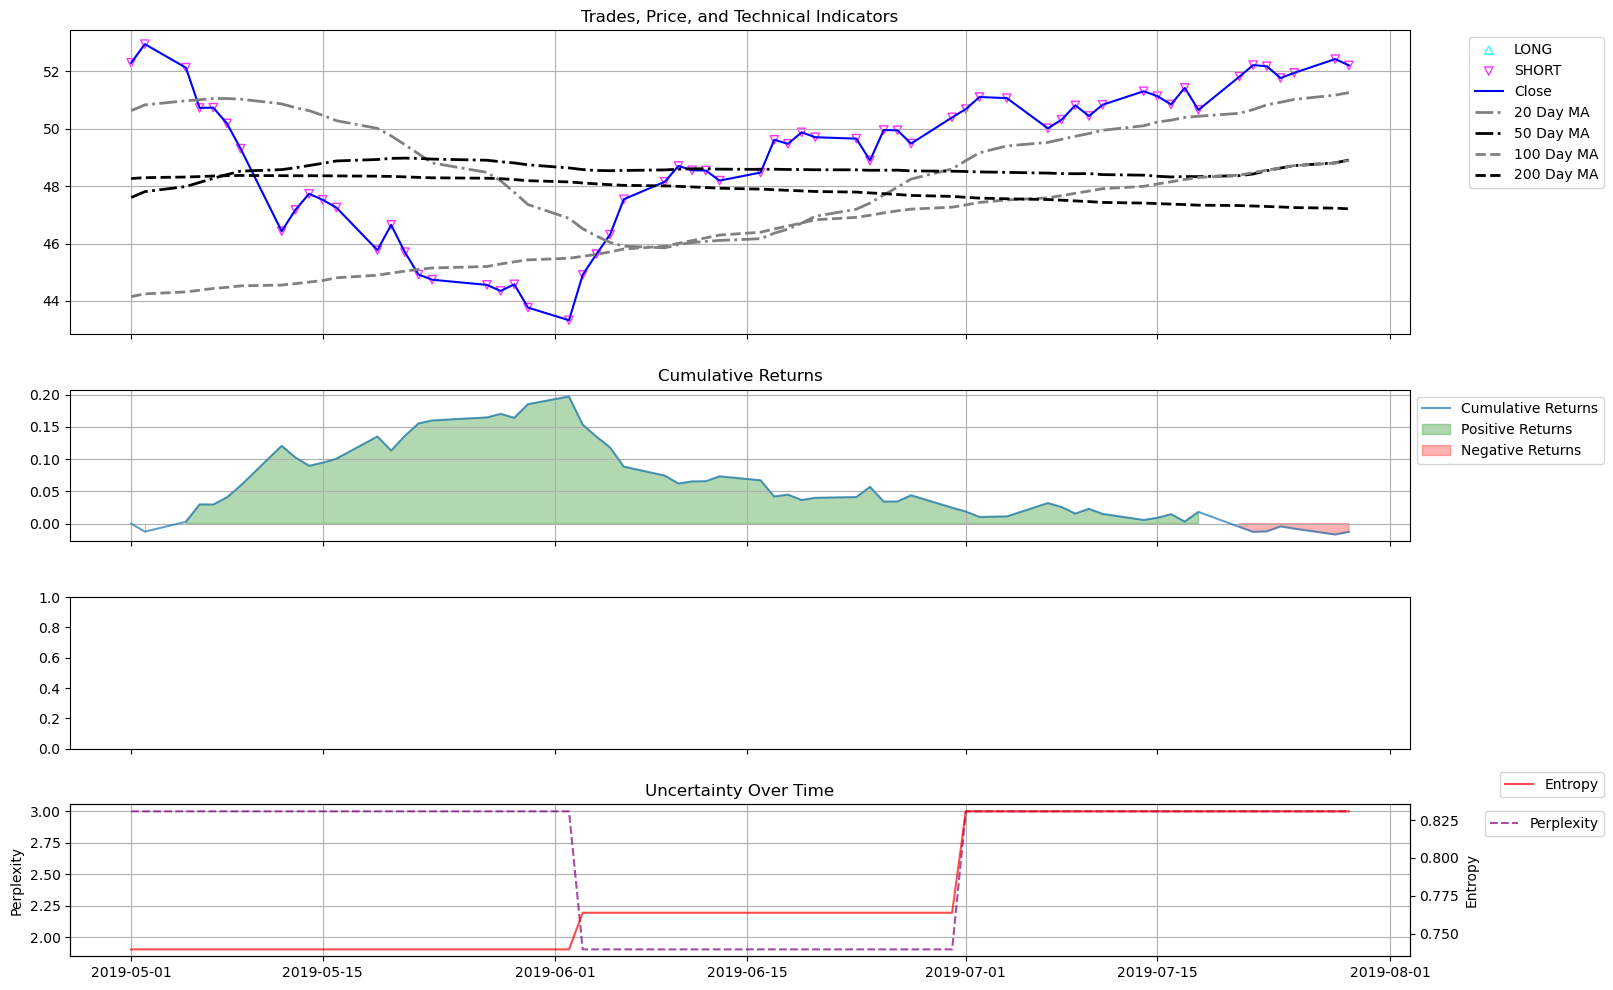

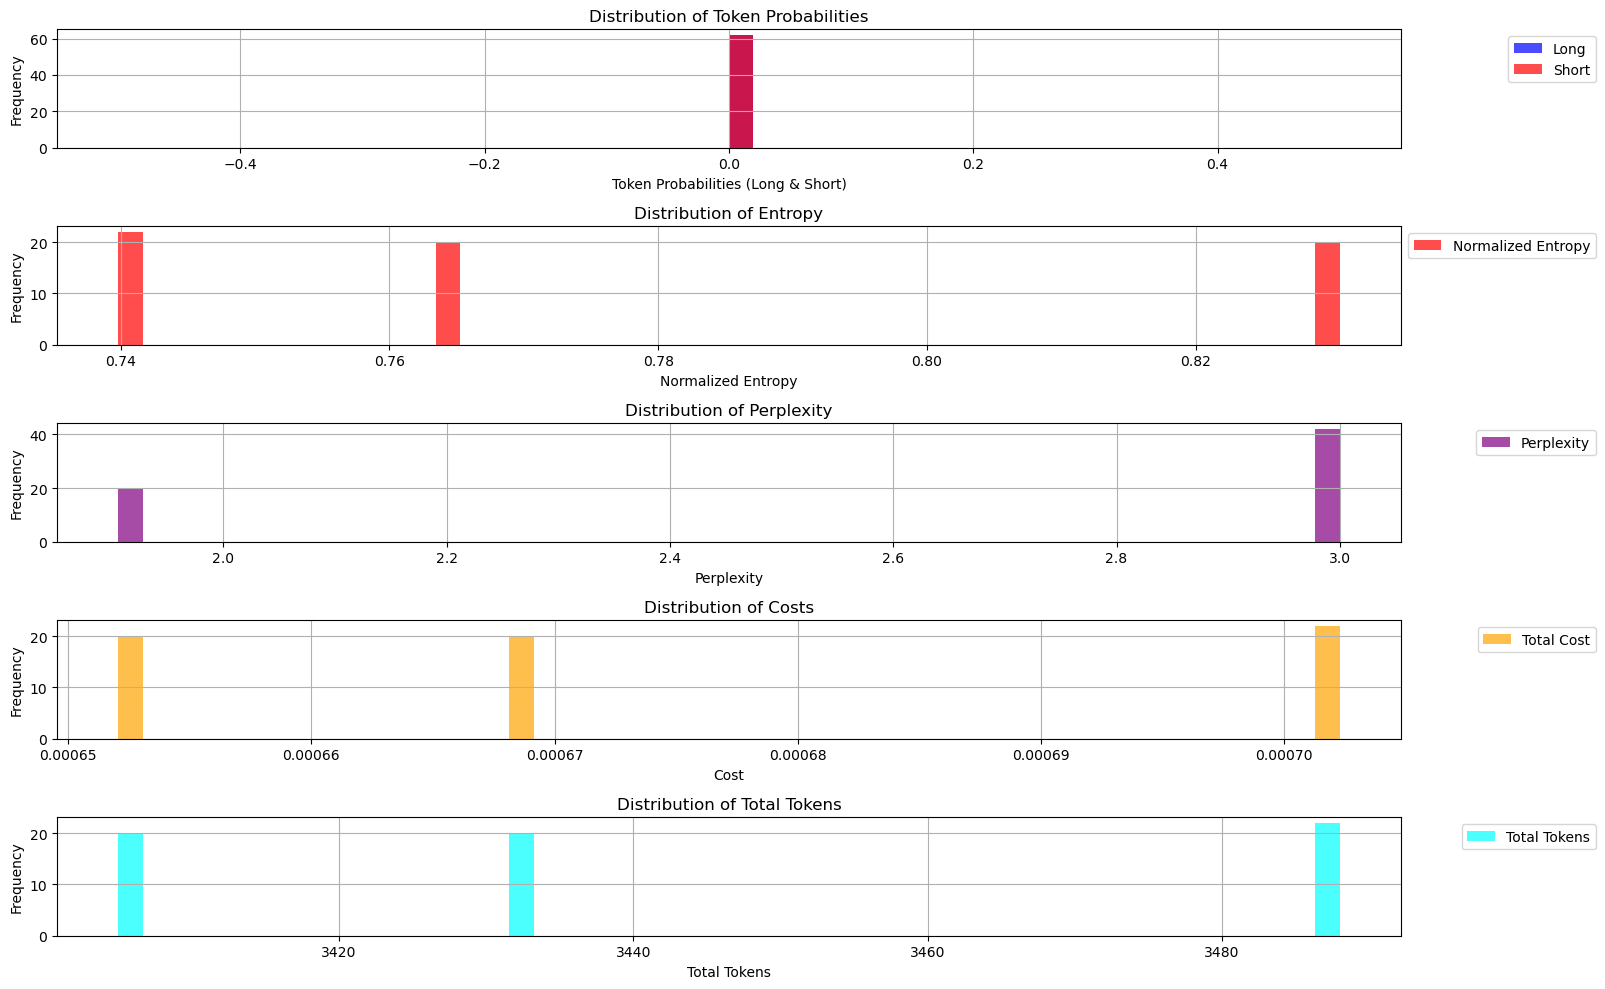

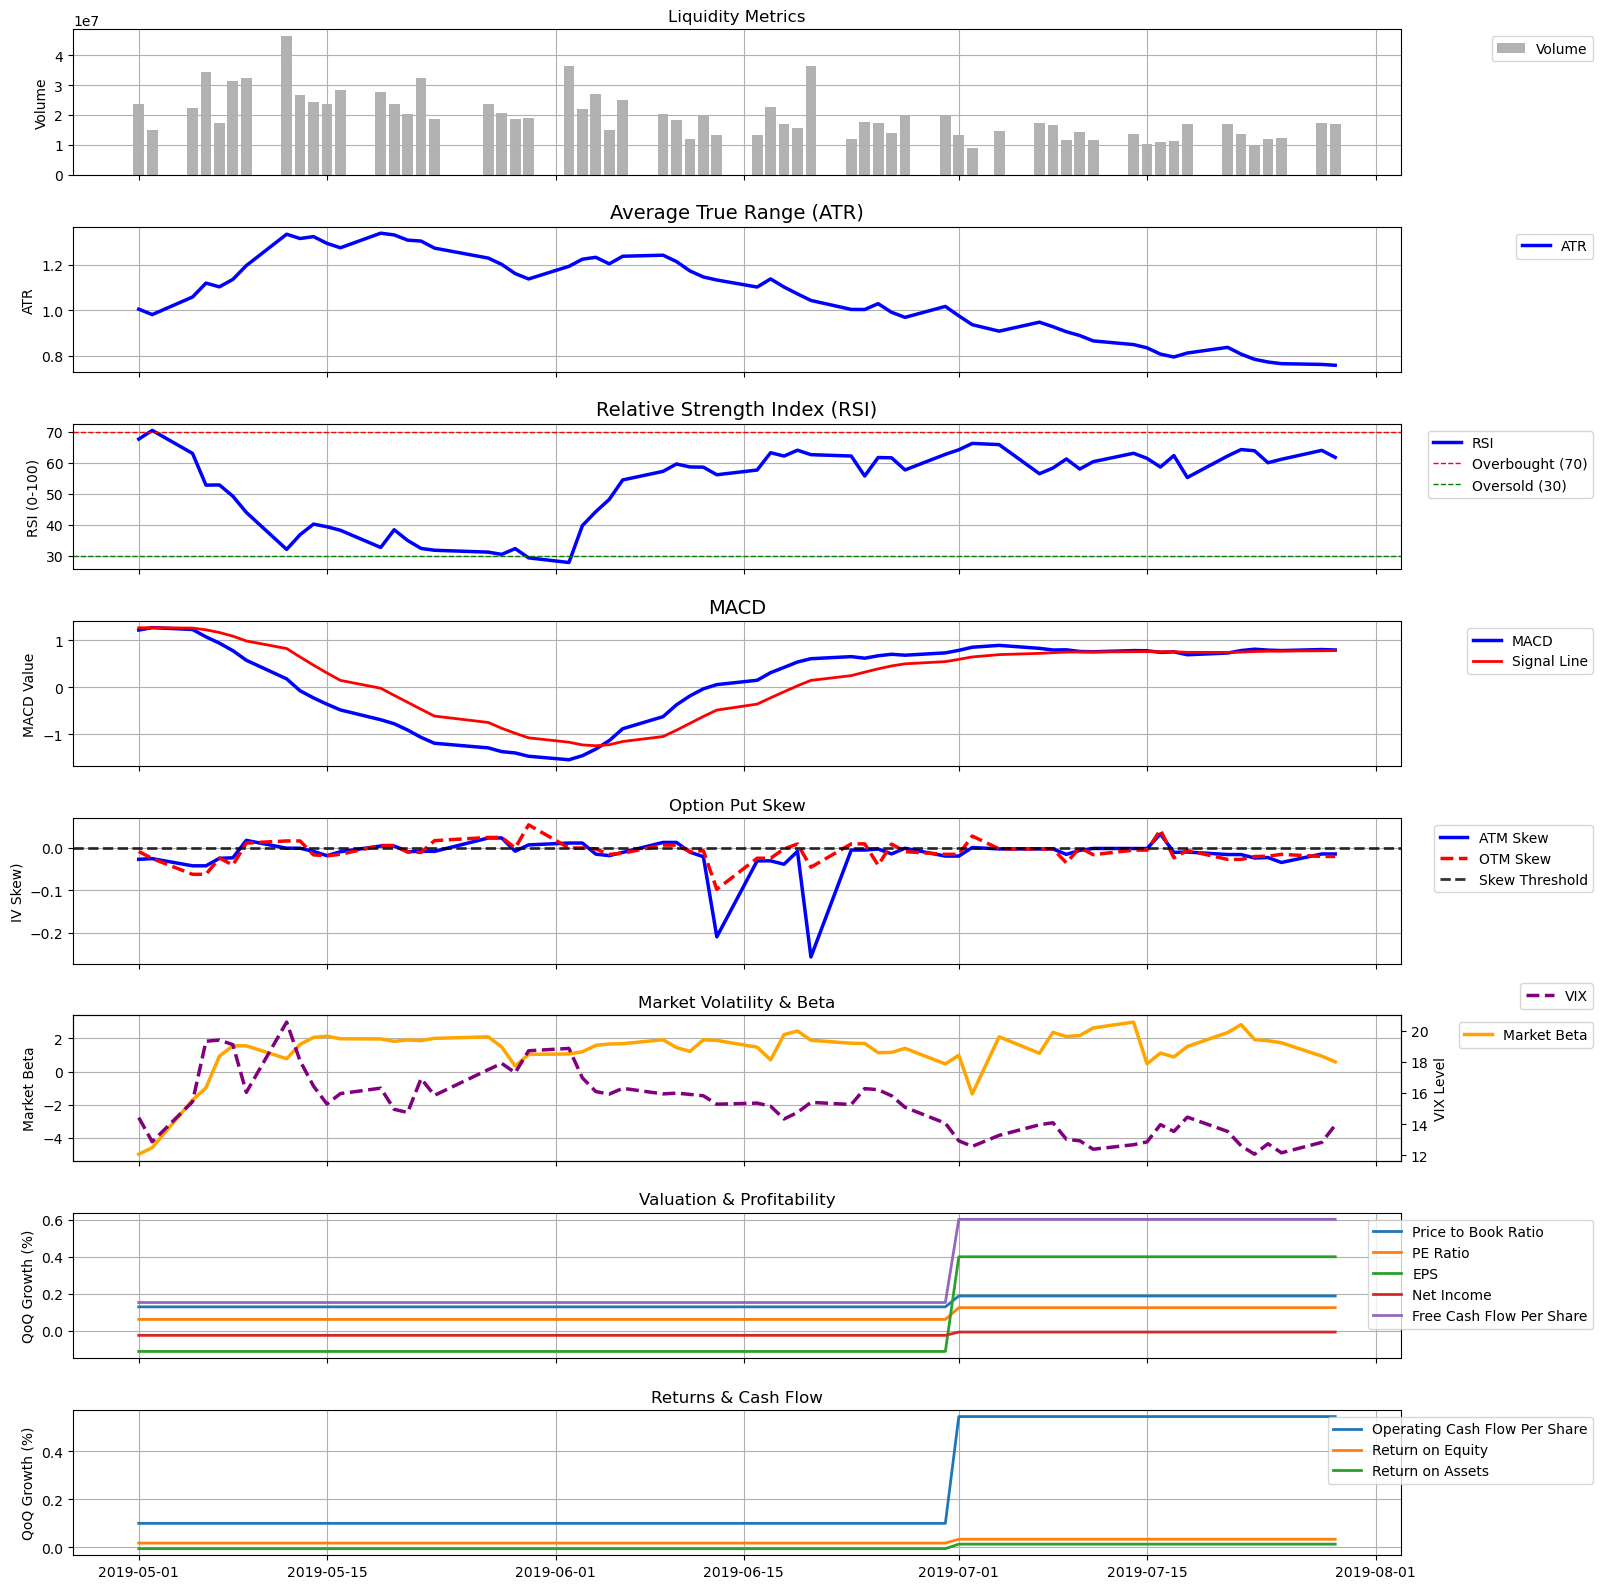

{'Sharpe Ratio (Annualized SR)': -0.09341517353231221,
 'Portfolio Turnover (PTR)': 0.0,
 'Maximum Drawdown (MDD)': 0.17890457718791786,
 'Mean Drawdown Duration (MDDur)': 17.375,
 'Cumulative Returns': -0.012837725931590382,
 'Mean Perplexity': 2.64703679521942,
 'Mean Entropy': 0.7769137329568285,
 'Max Perplexity': 3.0,
 'Max Entropy': 0.830741580899906,
 'Mean Normalized Entropy': None,
 'Max Normalized Entropy': None,
 'Mean Tokens': 3443.483870967742,
 'Mean Costs': 0.0006752999999999999,
 'Max Tokens': 3488.0,
 'Max Costs': 0.0007022999999999999,
 'Total Tokens': 213496.0,
 'Total Costs': 0.04186859999999999}

In [13]:
llm_trading_metrics, llm_trades_df = evaluate_trading_metrics(llm_decisions_df)
plot_llm_trade(llm_trades_df)

llm_trading_metrics

In [14]:
sample_start_date = pd.Timestamp("2019-01-01 00:00:00+01:00")
sample_end_date = pd.Timestamp("2019-03-01 00:00:00+01:00")

engineered_sample_df = stock_aug_data.loc[sample_start_date:sample_end_date]
expert_sample_df = expert_df.loc[sample_start_date:sample_end_date]

llm_decisions_df = llm_trades(
    engineered_df=engineered_sample_df,
    risk_profile=HIGH_RISK_PROFILE,
    objectives=HIGH_OBJECTIVES,
    persona=PERSONA,
    client=OPENAI_CLIENT,
    model=OPENAI_MODEL,
    expert_df=expert_df
)

Generating strategies...: 0it [00:00, ?it/s]

In [15]:
pprint(llm_decisions_df['explanation'].unique())

array(["The expert's decision to take a short position aligns with the analysis of various data categories, particularly focusing on momentum indicators and macroeconomic sentiment. The RSI at 35.21 suggests that the stock is nearing oversold territory, but given its divergence of 2.48, it indicates a potential for further downside before a reversal occurs, supporting the short strategy (Technical_Analysis.RSI). Additionally, the stock's historical volatility remains elevated at 0.4 across all metrics which reflects increased uncertainty in price movements (Stock_Data.Historical_Volatility.HV_Close). \n\nFrom a macro perspective, declining consumer confidence and employment figures paired with an increasing PMI indicate weakening economic conditions that could negatively impact growth sectors like technology (Economic_Data.Consumer_Confidence and Economic_Data.PMI). The high beta of 1.26 signals higher sensitivity to market movements; thus, any bearish sentiment can lead to more pronou

In [16]:
sample_start_date = pd.Timestamp("2019-04-01 00:00:00+01:00")
sample_end_date = pd.Timestamp("2019-05-30 00:00:00+01:00")

engineered_sample_df = stock_aug_data.loc[sample_start_date:sample_end_date]
expert_sample_df = expert_df.loc[sample_start_date:sample_end_date]

llm_decisions_df = llm_trades(
    engineered_df=engineered_sample_df,
    risk_profile=HIGH_RISK_PROFILE,
    objectives=HIGH_OBJECTIVES,
    persona=PERSONA,
    client=OPENAI_CLIENT,
    model=OPENAI_MODEL,
    expert_df=expert_df
)


Generating strategies...: 0it [00:00, ?it/s]

In [17]:
pprint(llm_decisions_df['explanation'].unique())

array(["The expert's decision to initiate a short position is primarily driven by several interrelated factors from the provided data. Firstly, the RSI value of 69.84 indicates that the stock is approaching overbought territory, which historically suggests a potential price reversal. Coupled with this, the decreasing trend in historical volatility (HV) suggests diminishing price movement and potentially increased risk for long positions.\n\nAdditionally, while implied volatility remains relatively stable across different options metrics (ATM IV: 0.28; OTM IV: 0.27), there’s an observable pattern indicating market caution as reflected by low VIX levels (13.36). This low VIX combined with negative slopes in treasury yields (-0.01) points towards broader market uncertainty or risk aversion.\n\nFrom a fundamental perspective, though profitability margins such as EBIT margin (21.45) are strong, declining QoQ growth rates across various financial metrics indicate weakening performance moment

## Prompt Mining

In [18]:

def generate_sample_dates(dataframe, num_samples=15):
    timestamps = pd.to_datetime(dataframe.index, utc=True)
    min_time, max_time = timestamps.min(), timestamps.max()
    sample_dates = pd.date_range(start=min_time, end=max_time, periods=num_samples)
    return sample_dates

def generate_random_sample_dates(dataframe, num_samples=15):
    timestamps = pd.to_datetime(dataframe.index, utc=True)
    random_dates = np.random.choice(timestamps, size=num_samples, replace=False)
    return pd.to_datetime(random_dates)

def process_samples_for_ticker(
    ticker, engineered_df, expert_df, risk_profile, objectives,
    persona, client, model, num_samples=5, prompt_frequency='Monthly'
):
    sample_dates = generate_random_sample_dates(engineered_df, num_samples)
    corpus = []

    for anchor_date in tqdm(sample_dates, desc=f"Processing {ticker}", leave=False):
        if prompt_frequency == 'Monthly':
            start_date = anchor_date - pd.Timedelta(days=7)
            end_date = anchor_date + pd.Timedelta(days=37)
        elif prompt_frequency == 'Weekly':
            start_date = anchor_date - pd.Timedelta(days=1)
            end_date = anchor_date + pd.Timedelta(days=8)
        else:
            raise ValueError("Invalid prompt_frequency. Choose 'Weekly' or 'Monthly'.")

        sliced_df = engineered_df.loc[start_date:end_date].copy()
        if anchor_date not in sliced_df.index:
            continue

        try:
            trade_strategy = llm_trades(
                engineered_df=sliced_df,
                risk_profile=risk_profile,
                objectives=objectives,
                persona=persona,
                client=client,
                model=model,
                prompt_frequency=prompt_frequency,
                expert_df=expert_df
            )
            if trade_strategy is None:
                continue
            corpus.append({
                "ticker": ticker,
                "anchor_date": str(anchor_date),
                "context": context_yaml,
                "explanation": trade_strategy.iloc[-1]['explanation'],
                "features": trade_strategy.iloc[-1]['features'],
            })
        except Exception as e:
            logging.error(e)

    return corpus


def process_multiple_tickers(tickers,
                                risk_profile,
                                objectives,
                                persona,
                                client,
                                model,
                                num_samples=15,
                                high_risk=True,
                                startingDate=START_DATE,
                                endingDate=END_DATE):
    full_corpus = []
    for ticker in tqdm(tickers):
        print(f"Processing Ticker: {ticker}")

        input_file = f"{HISTORIC_PATH}/engineered_{ticker}_data.parquet"
        engineered_df = pd.read_parquet(input_file)
        engineered_df.set_index('Date', inplace=True)
        expert_df = expert_trades(stock_aug_data.copy(), high_risk=high_risk)

        start_date = pd.to_datetime(startingDate, utc=True)
        end_date = pd.to_datetime(endingDate, utc=True)
        engineered_df = engineered_df.loc[start_date:end_date]
        expert_df = expert_df.loc[start_date:end_date]

        ticker_corpus = process_samples_for_ticker(
            ticker=ticker,
            engineered_df=engineered_df,
            expert_df=expert_df,
            risk_profile=risk_profile,
            objectives=objectives,
            persona=persona,
            client=client,
            model=model,
            num_samples=num_samples
        )
        full_corpus.extend(ticker_corpus)
    return full_corpus

corpus_file = "./risk_trade_strategy_corpus.yaml"
if os.path.exists(corpus_file):
    print(f"Corpus file '{corpus_file}' found. Reloading...")
    with open(corpus_file, "r") as f:
        corpus = yaml.safe_load(f)
else:
    print("Corpus file not found. Generating new corpus...")
    OPENAI_CLIENT = OpenAI(api_key=OPENAI_API_KEY)
    corpus = process_multiple_tickers(
        tickers= TICKERS,
        risk_profile=HIGH_RISK_PROFILE,
        objectives=HIGH_OBJECTIVES,
        persona=PERSONA,
        client=OPENAI_CLIENT,
        model=OPENAI_MODEL,
        num_samples=PROMPT_SAMPLES,
    )
    with open(corpus_file, "w") as f:
        yaml.dump(corpus, f, default_flow_style=False, allow_unicode=True, indent=2)
    print("Corpus saved successfully.")

print("Corpus ready for use.")

Corpus file './risk_trade_strategy_corpus.yaml' found. Reloading...
Corpus ready for use.


## Prompt Generation


### Exemplars Selection

Need to finding the most similar explanations. Since we are using GPT-4 already, `text-embedding-3-small` or `text-embedding-ada-002` is good.

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

def load_corpus(file_path):
    with open(file_path, "r") as f:
        return yaml.safe_load(f)

def get_or_compute_embeddings(explanations, client, model="text-embedding-3-small", cache_path="embeddings_cache.pkl"):
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            return pickle.load(f)

    embeddings = []
    for i in tqdm(range(0, len(explanations), 100), desc="Embedding"):
        batch = explanations[i:i+100]
        response = client.embeddings.create(input=batch, model=model)
        batch_embeddings = [e.embedding for e in response.data]
        embeddings.extend(batch_embeddings)

    with open(cache_path, "wb") as f:
        pickle.dump(embeddings, f)

    return embeddings
def select_diverse_relevant_exemplars(explanations, embeddings, num_exemplars=10, seed_explanation=None):
    kmeans = KMeans(n_clusters=num_exemplars, random_state=42).fit(embeddings)
    cluster_labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    selected = []
    for i in range(num_exemplars):
        cluster_indices = np.where(cluster_labels == i)[0]
        cluster_embeds = [embeddings[j] for j in cluster_indices]

        if seed_explanation:
            seed_embed = embeddings[explanations.index(seed_explanation)]
            sims = cosine_similarity([seed_embed], cluster_embeds)[0]
        else:
            sims = cosine_similarity([centroids[i]], cluster_embeds)[0]

        best_idx = cluster_indices[np.argmax(sims)]
        selected.append(explanations[best_idx])

    return selected


corpus = load_corpus("./risk_trade_strategy_corpus.yaml")
explanations = [entry["explanation"] for entry in corpus]
embeddings = get_or_compute_embeddings(explanations, OPENAI_CLIENT)
exemplars = select_diverse_relevant_exemplars(explanations, embeddings, num_exemplars=10)

pprint(exemplars)

Embedding:   0%|          | 0/1 [00:00<?, ?it/s]

["The expert's decision to take a short position aligns with the high-risk "
 'profile and trading strategy focused on volatility and price action. A '
 'confluence of indicators suggests bearish momentum. The RSI value at 38.69 '
 'indicates a downtrend, while MACD shows negative strength, both reflecting '
 'weakness in stock performance. Furthermore, the rising VIX (14.8) signifies '
 'increased market risk aversion, which typically supports downward pressure '
 'on equity prices; this is corroborated by SPX close values declining against '
 'their moving averages (2935.73). Moreover, implied volatility (IV) levels '
 'across calls and puts are relatively high but stable around 0.18-0.17 '
 'without significant upward movements that would suggest bullish sentiment '
 'adjustments in option pricing.',
 "The expert's decision to take a short position aligns with the current "
 'market dynamics and company fundamentals, reflecting a substantial analysis '
 'of multiple data categories.

In [20]:
def extract_selected_features(corpus, max_features=10):
    from collections import Counter
    features = [f.strip() for entry in corpus for f in entry["features"].split(",")]
    required_groups = [
        "Stock_Data", "Options_Data", "Macro_Data",
        "Economic_Data", "Fundamental_Data", "Technical_Analysis"
    ]
    selected = []
    used = set()
    for group in required_groups:
        group_feats = [f for f in features if f.startswith(group)]
        if group_feats:
            top_feat = Counter(group_feats).most_common(1)[0][0]
            selected.append(top_feat)
            used.add(top_feat)
    remaining = [f for f, _ in Counter(features).most_common(30) if f not in used]
    selected += remaining[:max(0, max_features - len(selected))]
    return selected

features = extract_selected_features(corpus)
pprint(features)

['Stock_Data.General.Beta',
 'Options_Data.Atm_IV.Call',
 'Macro_Data.VIX.Close',
 'Economic_Data.PMI',
 'Fundamental_Data.Ratios.PE_Ratio',
 'Technical_Analysis.RSI.Value',
 'Stock_Data.Historical_Volatility.HV_Close',
 'Fundamental_Data.Margins.Net_Profit_Margin',
 'Options_Data.ATM_IV.Call',
 'Macro_Data.Economic_Data.PMI']


### Prompt Construction

We will define a meta-prompt to create the prompt that will generate a strategy.

In [21]:
def generate_instruction_block_from_exemplars(exemplars, client):
    meta_prompt = f"""
You are designing a prompt template for an LLM that generates trading strategies.

Below are exemplar rationales created by the system. Reflect on them and extract a generalized instruction block that guides how the LLM should analyze the context and reason about trading decisions.

Each rationale integrates technical, macroeconomic, fundamental, and options data. It connects these with the user's risk profile and portfolio objectives.

Return a clean YAML block with a single key: `instructions`. Do not include explanations or metadata.

Exemplars:
{yaml.dump(exemplars[:5])}
"""

    response = client.chat.completions.create(
        model="gpt-4",
        temperature=0.3,
        messages=[
            {"role": "system", "content": "You are a prompt engineer."},
            {"role": "user", "content": meta_prompt}
        ]
    )
    return yaml.safe_load(response.choices[0].message.content)["instructions"]


def call_gpt_to_generate_template(exemplars, features, persona, risk_profile, objectives, client):
    instructions = generate_instruction_block_from_exemplars(exemplars, client)

    system_prompt = (
        "You are a prompt engineer for financial LLMs. Your task is to generate a YAML prompt "
        "template (with placeholders) to guide an LLM in generating a trading strategy. Use the exemplars "
        "to infer the structure and tone, build the `instructions` from the exemplars. "
        "Ensure at least one feature from each category is included in `User_Context`, structured by their "
        "dot notation (e.g., Stock_Data.General.Beta -> Stock_Data > General > Beta)."
    )

    user_prompt = {
        "persona": persona,
        "risk_profile": risk_profile,
        "portfolio_objectives": objectives,
        "selected_features": features,
        "exemplars": exemplars[:5],
        "output_format": "YAML with keys `User_Context`, `System_Context`, `Output`. Use {placeholders}."
    }

    response = client.chat.completions.create(
        model="gpt-4",
        temperature=0.4,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": yaml.dump(user_prompt, default_flow_style=False, sort_keys=False)}
        ]
    )
    return response.choices[0].message.content

'''
generated_template = call_gpt_to_generate_template(
    exemplars=exemplars,
    features=selected,  # your extracted top features
    risk_profile=HIGH_RISK_PROFILE,
    objectives=HIGH_OBJECTIVES,
    persona=PERSONA,
    client=OPENAI_CLIENT
)

with open("llm_prompt_template_generated.yaml", "w") as f:
    f.write(generated_template)

pprint(generated_template)
'''


'\ngenerated_template = call_gpt_to_generate_template(\n    exemplars=exemplars,\n    features=selected,  # your extracted top features\n    risk_profile=HIGH_RISK_PROFILE,\n    objectives=HIGH_OBJECTIVES,\n    persona=PERSONA,\n    client=OPENAI_CLIENT\n)\n\nwith open("llm_prompt_template_generated.yaml", "w") as f:\n    f.write(generated_template)\n\npprint(generated_template)\n'

## Prompt EDA

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adamd1985/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/adamd1985/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


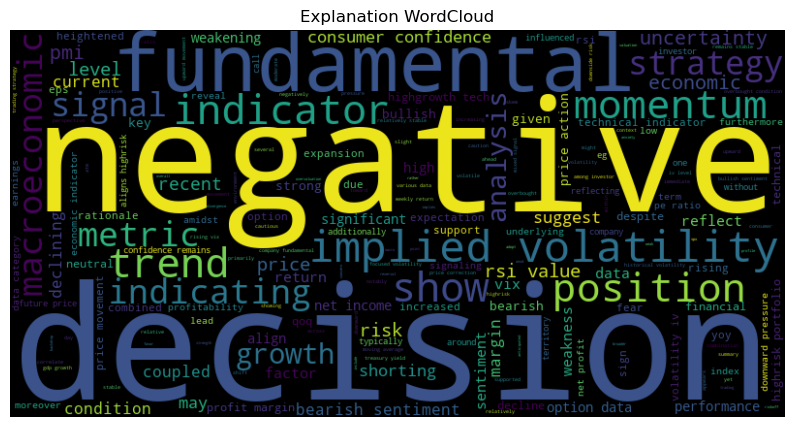

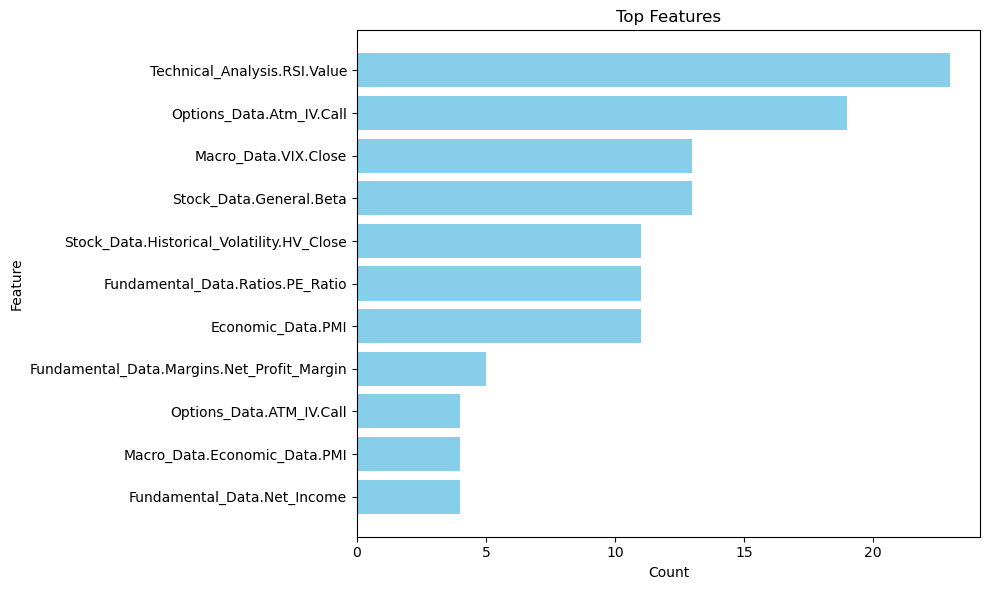

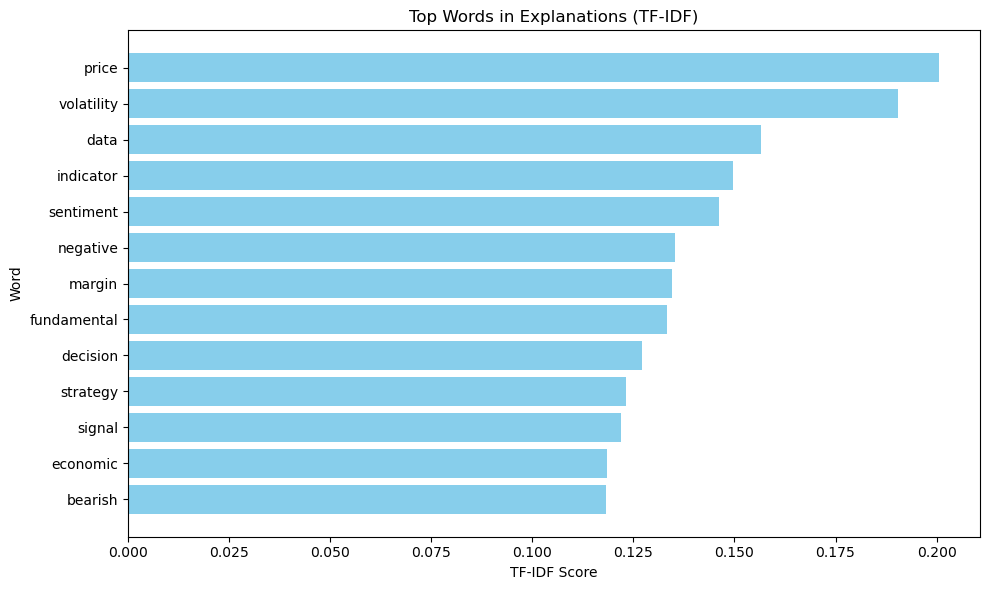

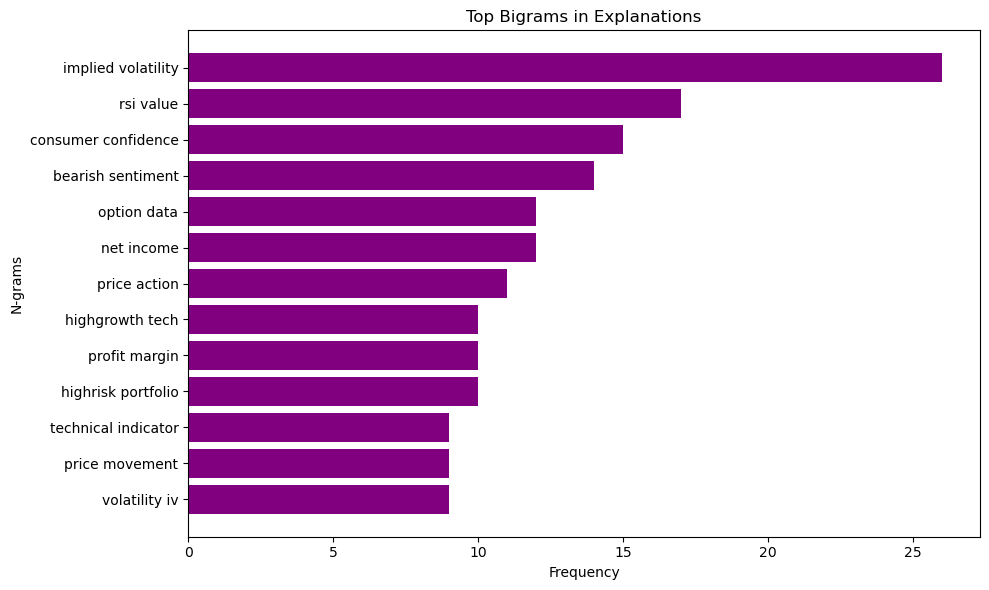

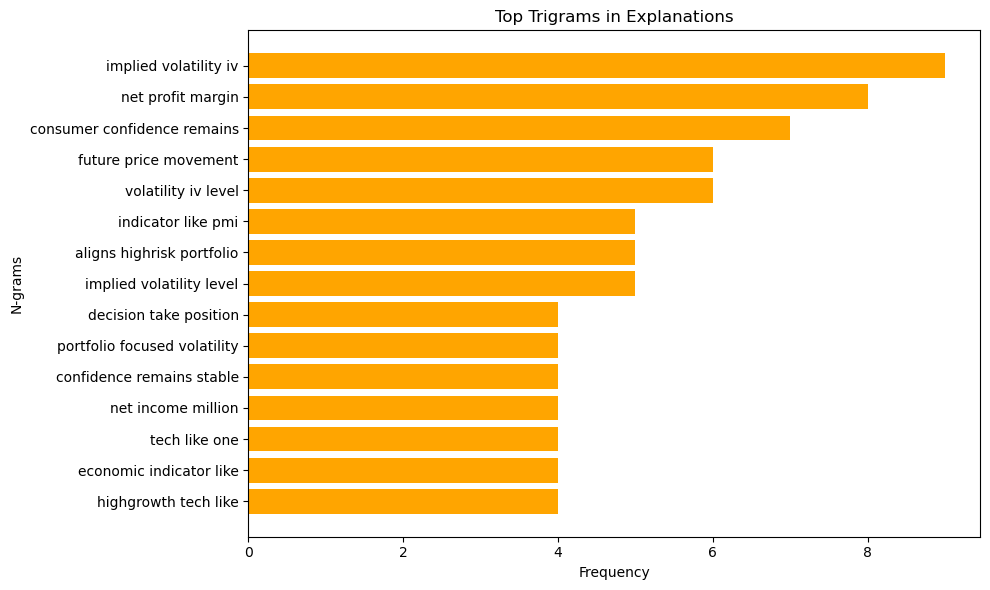

In [22]:
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download("stopwords")
nltk.download("wordnet")

WORD_COUNT = 50
TOP_FEATURES = 50

def clean_text(text, custom_stop_words=None):
    stop_words = set(stopwords.words("english"))
    if custom_stop_words:
        stop_words.update(custom_stop_words)
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    text = re.sub(r"\s+", " ", text).strip()
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

def clean_text_data(text_list, custom_stop_words=None):
    return [clean_text(text, custom_stop_words=custom_stop_words) for text in text_list]


def extract_corpus_data(corpus):
    explanations = [entry["explanation"] for entry in corpus]
    features = [f.strip() for entry in corpus for f in entry["features"].split(",")]
    return explanations, features

def compute_tfidf(data, max_features=TOP_FEATURES):
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(data)
    tfidf_scores = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    return tfidf_scores

def compute_word_frequencies(text_data):
    word_counter = Counter(" ".join(text_data).split())
    return pd.DataFrame(word_counter.most_common(WORD_COUNT), columns=["Word", "Count"])

def compute_ngrams(text_data, ngram_range=(2, 3), top_n=WORD_COUNT, custom_stop_words=None):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=custom_stop_words)
    ngram_matrix = vectorizer.fit_transform(text_data)
    ngram_counts = pd.DataFrame(
        ngram_matrix.toarray(), columns=vectorizer.get_feature_names_out()
    ).sum(axis=0).sort_values(ascending=False).head(top_n)
    return ngram_counts

def save_and_plot(fig, file_prefix, title):
    """Save the plot and display it."""
    filename = f"./images/{file_prefix}_{title.replace(' ', '_')}.png"
    os.makedirs("./images", exist_ok=True)
    fig.savefig(filename)
    plt.show()
    plt.close(fig)

def generate_wordcloud(data, title, file_prefix):
    wordcloud = WordCloud(width=800, height=400).generate(" ".join(data))
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title)
    save_and_plot(fig, file_prefix, title)

def plot_top_features(features, title, xlabel, ylabel, file_prefix):
    features_df = pd.DataFrame(features, columns=[xlabel, ylabel])
    features_df = features_df[~features_df[xlabel].str.startswith('Next_')]

    # Compute top quartile threshold
    threshold = features_df[ylabel].quantile(0.75)
    top_quartile_df = features_df[features_df[ylabel] >= threshold]

    fig, ax = plt.subplots(figsize=(10, max(6, 0.3 * len(top_quartile_df))))  # dynamic height
    ax.barh(top_quartile_df[xlabel], top_quartile_df[ylabel], color="skyblue")
    ax.set_xlabel(ylabel)
    ax.set_ylabel(xlabel)
    ax.set_title(title)
    ax.invert_yaxis()
    fig.tight_layout()
    save_and_plot(fig, file_prefix, title)


def analyze_corpus_with_ngrams(file_path, file_prefix, overused_words=None):
    if overused_words is None:
        overused_words = ["stock", "potential", "suggesting", "suggests", "indicate", "indicates",
                          "explanation", "market", "gains", "quick", "expert", "objective", "feature",
                          "refined feature", "feature set", "refined set", "set emphasizes", "set",
                          "metrics", "metrics", "assess", "future prompt", "short", "long"]
    corpus = load_corpus(file_path)
    explanations, features = extract_corpus_data(corpus)
    clean_explanations = clean_text_data(explanations, custom_stop_words=overused_words)
    tfidf_scores = compute_tfidf(clean_explanations)
    feature_counts = Counter(features)
    explanation_bigrams = compute_ngrams(clean_explanations, ngram_range=(2, 2), custom_stop_words=overused_words)
    explanation_trigrams = compute_ngrams(clean_explanations, ngram_range=(3, 3), custom_stop_words=overused_words)
    generate_wordcloud(clean_explanations, "Explanation WordCloud", file_prefix)
    plot_top_features(feature_counts.most_common(WORD_COUNT), "Top Features", "Feature", "Count", file_prefix)
    plot_top_features(tfidf_scores.mean(axis=0).sort_values(ascending=False).head(WORD_COUNT).items(),
                      "Top Words in Explanations (TF-IDF)", "Word", "TF-IDF Score", file_prefix)

    for ngrams, title, color in [
        (explanation_bigrams, "Top Bigrams in Explanations", "purple"),
        (explanation_trigrams, "Top Trigrams in Explanations", "orange"),
    ]:
        # Convert to DataFrame
        ngram_df = pd.DataFrame({ "ngram": ngrams.index, "freq": ngrams.values })

        # Apply top quartile filter
        threshold = ngram_df["freq"].quantile(0.75)
        top_ngram_df = ngram_df[ngram_df["freq"] >= threshold]

        fig, ax = plt.subplots(figsize=(10, max(6, 0.3 * len(top_ngram_df))))
        ax.barh(top_ngram_df["ngram"], top_ngram_df["freq"], color=color)
        ax.set_xlabel("Frequency")
        ax.set_ylabel("N-grams")
        ax.set_title(title)
        ax.invert_yaxis()
        fig.tight_layout()
        save_and_plot(fig, file_prefix, title)


analyze_corpus_with_ngrams(corpus_file, "risk_version1")

# Low Risk Experiment

In [23]:
expert_df = expert_trades(stock_aug_data.copy(), high_risk=False)

print(expert_df.columns)
expert_df.tail(3)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'IV_Open', 'IV_High',
       'IV_Low', 'IV_Close', 'IV_Volume',
       ...
       'content', 'Entry_Point', 'Take_Profit', 'Stop_Loss', 'Timeframe',
       'Expert_Action', 'trade_action', 'Next_Day_Returns',
       'Next_Week_Returns', 'Next_Month_Returns'],
      dtype='object', length=295)


,Open,High,Low,Close,Volume,IV_Open,IV_High,IV_Low,IV_Close,IV_Volume,...,content,Entry_Point,Take_Profit,Stop_Loss,Timeframe,Expert_Action,trade_action,Next_Day_Returns,Next_Week_Returns,Next_Month_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-28 00:00:00+00:00,138.06,138.78,134.35,134.87,15324630.0,0.388195,0.402816,0.376258,0.377369,1.0,...,[<p>The rise of bitcoin has been one of the to...,136.2187,128.1265,156.651505,20.0,SHORT,0,-0.008527,NaN,NaN
2020-12-29 00:00:00+00:00,135.54,135.99,133.40,133.72,11611722.0,0.382607,0.387100,0.375305,0.380417,1.0,...,[<p>Some people see day trading as a dream job...,135.0572,127.0340,155.315780,20.0,SHORT,0,-0.007703,NaN,NaN
2020-12-30 00:00:00+00:00,134.05,134.73,131.73,132.69,11174161.0,0.384131,0.387116,0.376623,0.383544,1.0,...,"[<p>In the exchange traded funds industry, rec...",134.0169,126.0555,154.119435,20.0,SHORT,0,NaN,NaN,NaN


In [24]:
sample_start_date = pd.Timestamp("2019-06-01 00:00:00+02:00")
sample_end_date = pd.Timestamp("2019-07-30 00:00:00+02:00")

engineered_sample_df = stock_aug_data.loc[sample_start_date:sample_end_date]
expert_sample_df = expert_df.loc[sample_start_date:sample_end_date]
engineered_sample_df.tail(3)

,Open,High,Low,Close,Volume,IV_Open,IV_High,IV_Low,IV_Close,IV_Volume,...,Volume_Weighted_Returns,BB_Upper,BB_Middle,BB_Lower,BB_Width,IV_Percentile,VIX_Impact,Momentum_Long,Momentum_Short,content
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-25 00:00:00+00:00,51.85,52.43,51.85,51.94,12299492.0,0.259834,0.260024,0.246753,0.249627,1.0,...,87067.714204,52.344475,51.978,51.611525,0.014111,0.000000,21.025475,True,False,[<p>Shares of <strong>Intel Corporation </stro...
2019-07-28 00:00:00+00:00,52.12,52.66,52.11,52.42,17333512.0,0.247611,0.261802,0.247611,0.259358,1.0,...,41194.765580,52.556596,52.100,51.643404,0.017421,0.901471,11.891137,True,False,"[<p>On <a href=""https://www.cnbc.com/video/201..."
2019-07-29 00:00:00+00:00,52.19,52.54,51.83,52.20,16886052.0,0.258389,0.273407,0.255167,0.261152,1.0,...,5980.544385,52.552735,52.098,51.643265,0.017423,1.000000,8.150233,True,False,[<p>Earnings season is upon us! As the markets...


In [25]:
llm_decisions_df = llm_trades(
    engineered_df=engineered_sample_df,
    risk_profile=LOW_RISK_PROFILE,
    objectives=LOW_OBJECTIVES,
    persona=PERSONA,
    client=OPENAI_CLIENT,
    model=OPENAI_MODEL,
    expert_df=expert_df,
)
print(llm_decisions_df['explanation'].unique())

Generating strategies...: 0it [00:00, ?it/s]

[nan
 "The expert's decision to short the stock aligns with a low-risk trading strategy that seeks to minimize volatility and drawdowns. Key data points reveal a bearish outlook, particularly in the context of technical indicators, macroeconomic conditions, and options sentiment. The RSI at 27.88 indicates oversold conditions but also shows significant divergence, suggesting potential downward momentum rather than recovery in the near term. Historical volatility remains elevated at 0.35, highlighting increased uncertainty in price movements.\n\nFrom a macro perspective, the SPX index shows a decline relative to its moving average (2774.16), indicating bearish market sentiment reinforced by a rising VIX (18.86) that reflects increasing fear among investors—a classic risk-off signal.\n\nFundamentally, while net income stands strong at $55 billion with an ROI of 33%, other metrics such as EBIT margin (-0.07 QoQ growth) and declining EPS (-0.11) raise concerns about future profitability am

In [26]:

corpus_file = "./norisk_trade_strategy_corpus.yaml"
if os.path.exists(corpus_file):
    print(f"Corpus file '{corpus_file}' found. Reloading...")
    with open(corpus_file, "r") as f:
        corpus = yaml.safe_load(f)
else:
    print("Corpus file not found. Generating new corpus...")
    OPENAI_CLIENT = OpenAI(api_key=OPENAI_API_KEY)

    corpus = process_multiple_tickers(
        tickers=TICKERS,
        risk_profile=LOW_RISK_PROFILE,
        objectives=LOW_OBJECTIVES,
        persona=PERSONA,
        client=OPENAI_CLIENT,
        model=OPENAI_MODEL,
        high_risk=False,
        num_samples=PROMPT_SAMPLES,
    )

    with open(corpus_file, "w") as f:
        yaml.dump(corpus, f, default_flow_style=False, allow_unicode=True, indent=2)

    print("Corpus saved successfully.")

print("Corpus ready for use.")

Corpus file './norisk_trade_strategy_corpus.yaml' found. Reloading...
Corpus ready for use.


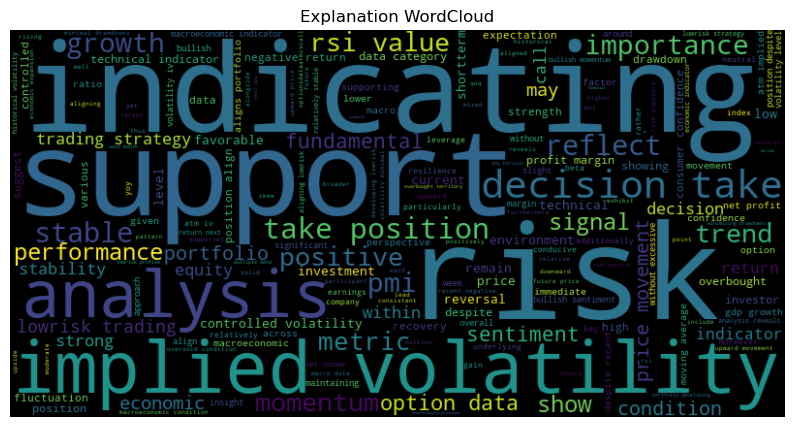

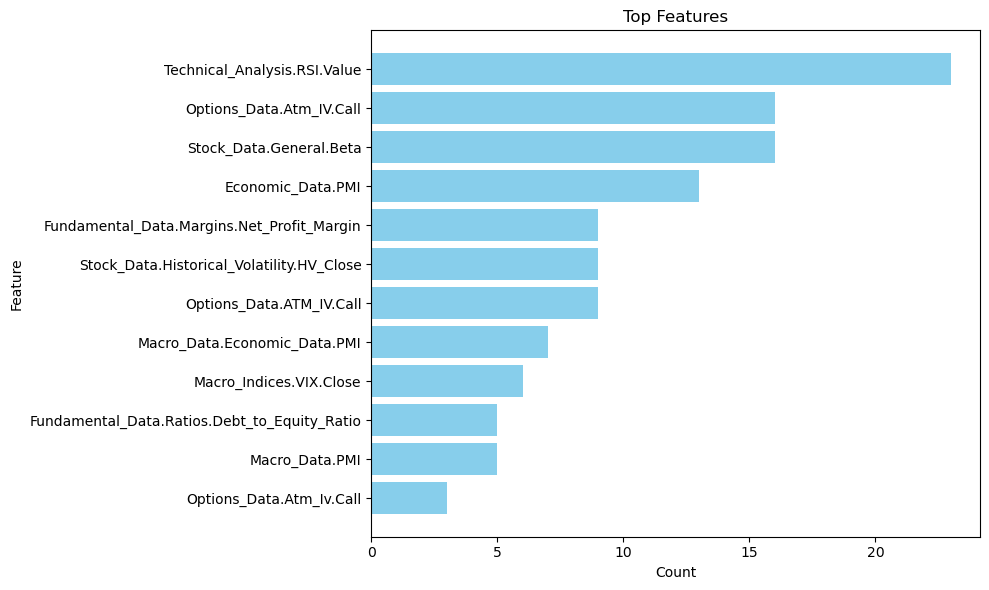

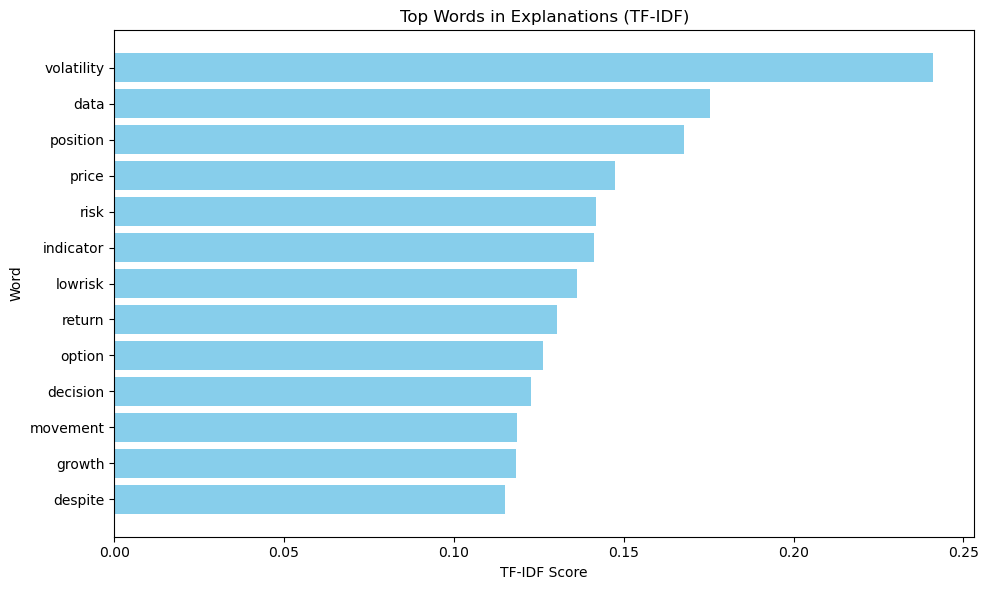

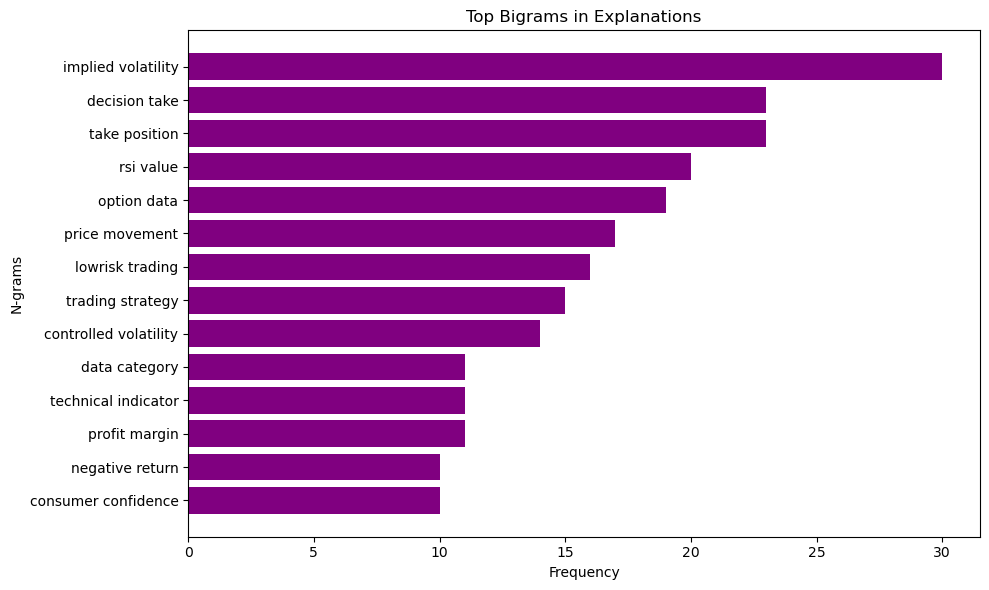

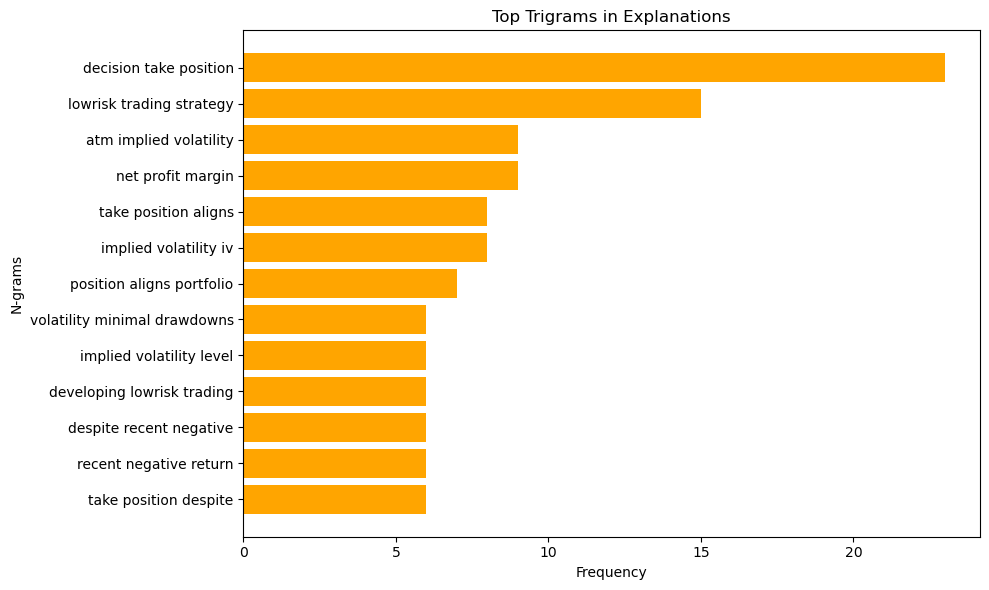

In [27]:
analyze_corpus_with_ngrams(corpus_file, "norisk_version1")